In [1]:
import numpy as np
from fbm import fbm, times
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score

I) Simulation of a rough volatility process 

In [93]:
nu,X0,alpha=0.3,-5,5*10**(-4)
m=X0
H=0.147
def log_vol(T,lag,H):
    delta=lag/252
    N=int(T/delta)
    X=np.zeros(N)
    X[0]=X0
    W = fbm(N-1, H, length=T, method='daviesharte')
    for i in range(len(W)-1):
        X[i+1]=X[i]+(W[i+1]-W[i])*nu+alpha*(m-X[i])*delta
    return(X)

def hist(X_simu):
    res=50
    A,B,C,D=np.array([]),np.array([]),np.array([]),np.array([])
    for i in X_simu:
        A = np.concatenate((A, np.diff(i[::1*10**3])))
        B = np.concatenate((B, np.diff(i[::5*10**3])))
        C = np.concatenate((C, np.diff(i[::25*10**3])))
        D = np.concatenate((D, np.diff(i[::125*10**3])))
    plt.subplot(2, 2, 1)
    plt.hist(np.diff(A),res,label="1 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()
    plt.title("The distribution of the log-volatility increments for H = "+str(H))

    plt.subplot(2,2,2)
    plt.hist(np.diff(B),res,label="5 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.hist(np.diff(C),res,label="25 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.hist(np.diff(D),res,label="125 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()
    plt.show()

Simulating a huge amount of data

In [ ]:
X_simu=np.array([log_vol(1,10**(-4),0.147) for i in range(120)])

Distribution of log-volatility increments

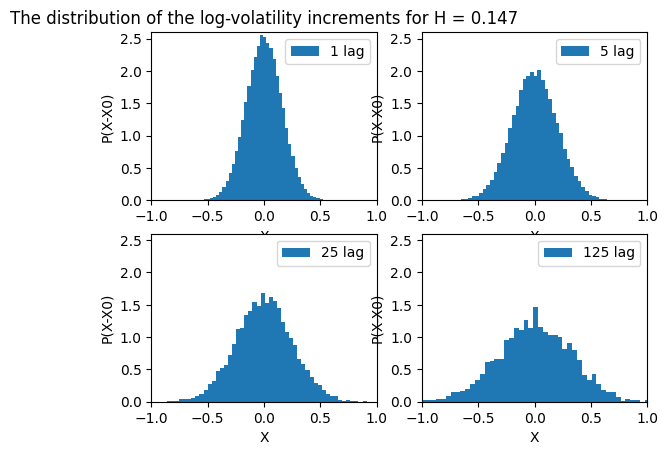

In [56]:
hist(X_simu)

We see that the distribution of the log-volatility increments is close to a Gaussian.


2) A method to determine the H exponent

In [97]:
def M(X,q,lag):
    a=np.mean(abs(np.diff(X[::int(lag)]))**q)
    return(a)

def H_exp_model(X_sim,plot):
    Delta=np.arange(1,251,1)
    Q=[0.5,1,1.5,2,3]
    Y=np.zeros(len(Delta)) 
    h_exp=0
    for q in Q:
        i=0
        for d in Delta:
            Em=0
            for X in X_sim:
                Em+=M(X,q,d)
            Y[i]=Em/len(X_sim)
            i+=1
        Y=np.log10(Y)
        slope, intercept,a,b,c= stats.linregress(np.log10(Delta),Y)
        x=[0,2.5]
        y=[0*slope+intercept,2.5*slope+intercept]
        plt.plot(x,y)
        h_exp+=slope/q/len(Q)
        plt.scatter(np.log10(Delta),Y,marker=".",s=10)
    plt.title("H theoric = "+str(H)+", H experimental = "+str(h_exp))
    plt.xlabel(r"$\log(\Delta)$")
    plt.ylabel(r"$\log(m(q,\Delta))$")
    if plot:
        plt.show()
    else:
        plt.clf()
    return(h_exp)

Scaling of the moments and monofractality


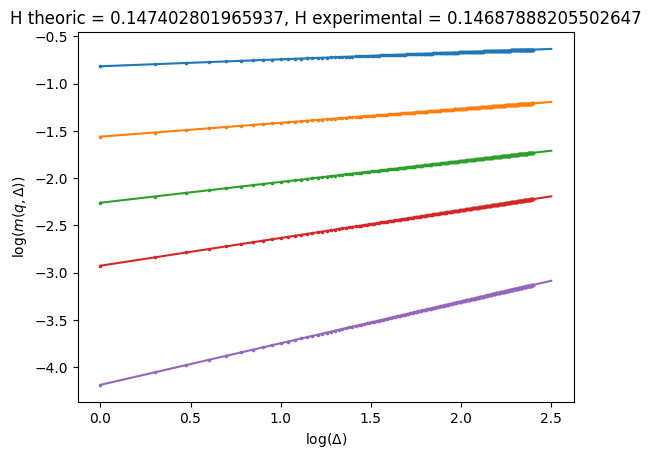

0.14687888205502647

In [105]:
H_exp_model(X_simu,True)

Importing real datas

In [256]:
a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
D=a["SPX2.rv"].tolist()

for k in range(len(D)):
    if str(D[k])=="nan":
        D[k]=D[k-1]
d=np.log10(D)
a["DateID"] = pd.to_datetime(a['DateID'],format='%Y%m%d')
a['year'] = pd.DatetimeIndex(a['DateID']).year
years = set(a["year"].values)
T=[]
for year in years:
    dyear= a[a["year"] == year]["SPX2.rv"].tolist()
    dyear=np.log10(dyear)
    for k in range(len(dyear)):
        if str(dyear[k])=="nan":
            dyear[k]=dyear[k-1]
    T.append(dyear)

In [109]:
def H_exp(X,plot):
    Delta=np.logspace(1,2.1,100)
    Q=[0.5,0.75,1,1.25,1.5,2]
    Y=np.zeros(len(Delta))   
    h_exp=0
    for q in Q:
        i=0
        for d in Delta:   
            Em=M(X,q,d)
            Y[i]=Em
            i+=1
        Y=np.log10(Y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(Delta),Y)
        x=[1,2.1]
        y=[1*slope+intercept,2.1*slope+intercept]
        plt.plot(x,y)
        h_exp+=slope/q/len(Q)
        plt.scatter(np.log10(Delta),Y,marker=".",s=10)
    plt.title("H experimental = "+str(h_exp))
    plt.xlabel(r"$\log(\Delta)$")
    plt.ylabel(r"$\log(m(q,\Delta))$")
    if plot:
        plt.show()
    else:
        plt.clf()
    return(h_exp)

def histo(X):
    plt.subplot(2, 2, 1)
    plt.hist(np.diff(X[::1]),30,label="1 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()
    plt.title("The distribution of the log-volatility increments")

    plt.subplot(2,2,2)
    plt.hist(np.diff(X[::3]),30,label="3 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()


    plt.subplot(2, 2, 3)
    plt.hist(np.diff(X[::10]),30,label="10 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()


    plt.subplot(2, 2, 4)
    plt.hist(np.diff(X[::30]),30,label="30 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()
    plt.show()

def moving_average_exp(table,t,L):
    slice=table[t:L*260+t]
    return H_exp(slice,False)

def moving_average_simu(X_sim,t):
    n=int(len(X_sim[0])/2)
    slice=X_sim[:,t:n+t]
    return H_exp_model(slice,False)

Now with real data

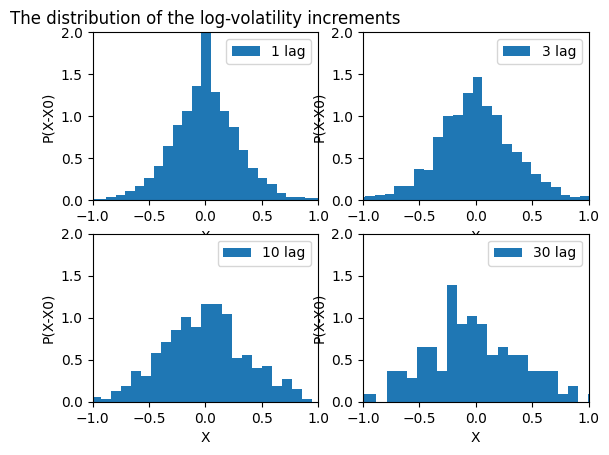

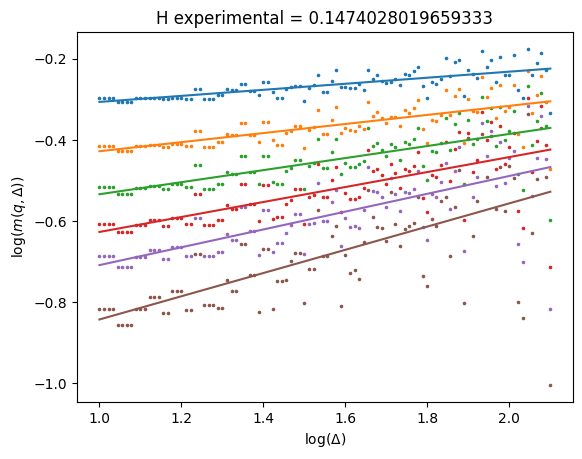

In [110]:
histo(d)
h_exp=H_exp(d,True)

Illustrating H-time dependancy

In [111]:
H=0.147402801965937
#14 years
L=9
Delta=np.arange(0,(14-L)*260,10)
Y,Z=[],[]
jump=2100000/((14-L)*260)
for delta in Delta:
    Y.append(moving_average_exp(d,int(delta),L))
    Z.append(moving_average_simu(X_simu[:1],int(jump*(delta))))

<Figure size 640x480 with 0 Axes>

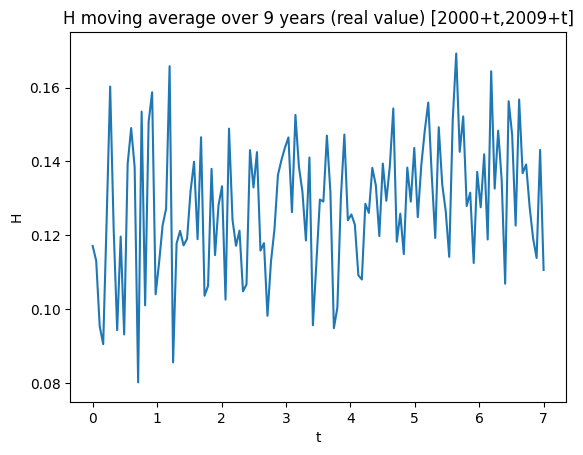

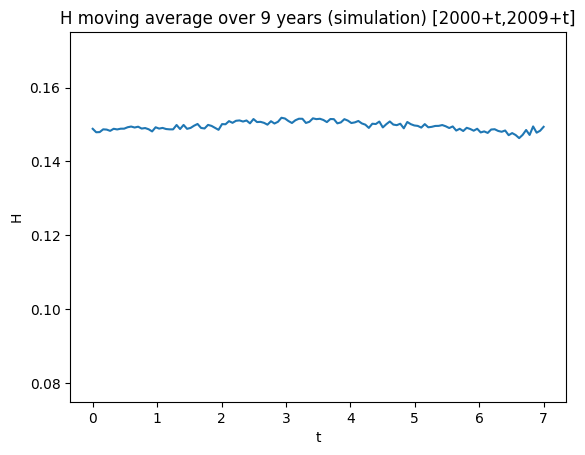

In [115]:
T=np.linspace(0,7,len(Y))

plt.title(f"H moving average over {L} years (real value) [2000+t,2009+t]")
plt.xlabel("t")
plt.ylabel("H")
plt.plot(T,Y)
plt.ylim([0.075,0.175])
plt.show()
plt.plot(T,Z)
plt.title(f"H moving average over {L} years (simulation) [2000+t,2009+t]")
plt.xlabel("t")
plt.ylabel("H")
plt.ylim([0.075,0.175])
plt.show()


In [258]:
def pred_sigma(log_sigmasquare,delta,H):
    pred = 0
    coeff=((delta**(H+1/2))*np.cos(H*np.pi)/np.pi)
    for k in range(len(log_sigmasquare)):
        d=(k+delta+1/2)*((k+1/2)**(H+1/2))
        a=log_sigmasquare[-k-1]/d
        pred+=a
    return(pred*coeff)

def P(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)]) #X[k]=log sigma [k+delta]
    bias=np.mean(dtilde/X)
    return(X*bias,1-r2_score(dtilde,X*bias))

def plot(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)])
    plt.plot(dtilde,label="Real")
    plt.plot(X*np.mean(dtilde/X),label="Pred")
    plt.legend()
    plt.show()

X,a=P(1)
plt.plot(D[5:])
plt.plot(10**X[5:])

plt.show()

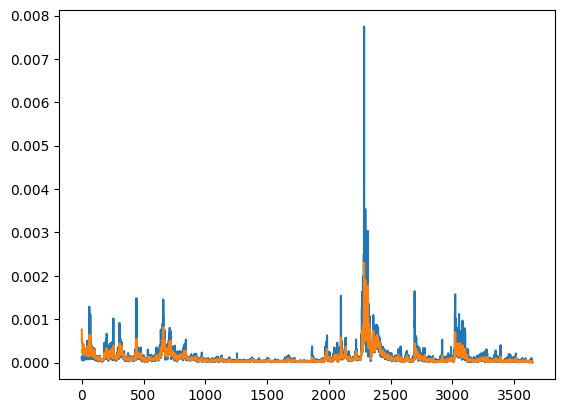

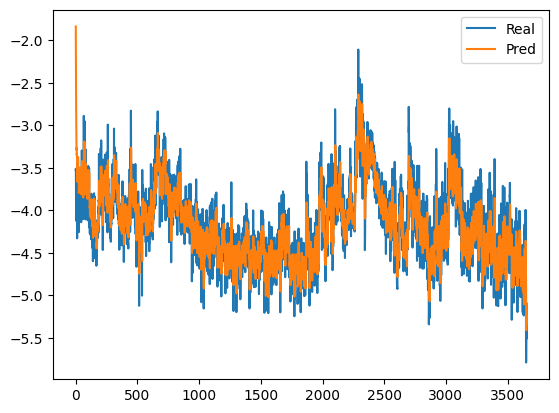

0.32013212738145524


In [262]:
a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
D=a["SPX2.rv"].tolist()

for k in range(len(D)):
    if str(D[k])=="nan":
        D[k]=D[k-1]
d=np.log10(D)

def pred_sigma(log_sigmasquare,delta,H):
    pred = 0
    coeff=((delta**(H+1/2))*np.cos(H*np.pi)/np.pi)
    for k in range(len(log_sigmasquare)):
        d=(k+delta+1/2)*((k+1/2)**(H+1/2))
        a=log_sigmasquare[-k-1]/d
        pred+=a
    return(pred*coeff)

def P(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)]) #X[k]=log sigma [k+delta]
    bias=np.mean(dtilde/X)
    return(X*bias,1-r2_score(dtilde,X*bias))

def plot(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)])
    plt.plot(dtilde,label="Real")
    plt.plot(X*np.mean(dtilde/X),label="Pred")
    plt.legend()
    plt.show()

X,a=P(1)
plt.plot(D[5:])
plt.plot(10**X[5:])
plt.show()
plot(1)
print(P(1)[1])

The P score obtained for $\Delta=1$ is 0.32 

Autocorrelation structures

In [217]:
X_14=np.array([log_vol(14,1,0.147) for i in range(50)])

In [246]:
def autocorr_empirique(x,delta):
    mean = np.mean(x)
    n=len(x)
    z=(x[:n-delta]-mean)*(x[delta:]-mean)
    return(np.mean(z))

def autocorr(x_simu,delta):
    mea=0
    for x in x_simu:
        mea+=autocorr_empirique(x,delta)
    return(mea/len(x_simu))

a=X_simu[:,:8000]
a=a**10
Delta=np.arange(1000)
Delta2=np.arange(len(D)-2600)

A1=[autocorr(a,delta) for delta in Delta]

B1=[np.log10(autocorr(a,delta)) for delta in Delta]

C1=[autocorr(np.log10(a),delta) for delta in Delta]

A2=[autocorr_empirique(D,delta) for delta in Delta2]

B2=[np.log10(autocorr_empirique(D,delta)) for delta in Delta2]

C2=[autocorr_empirique(np.log10(D),delta) for delta in Delta2]

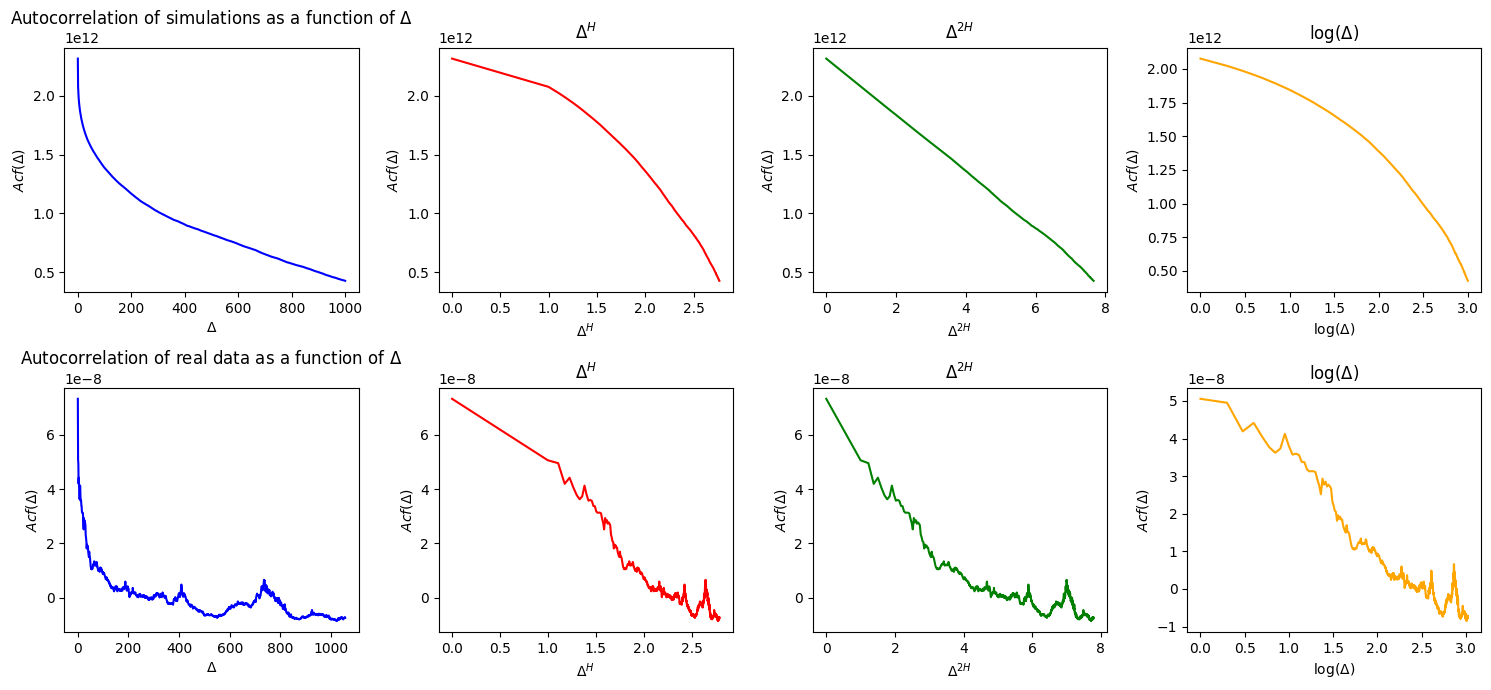

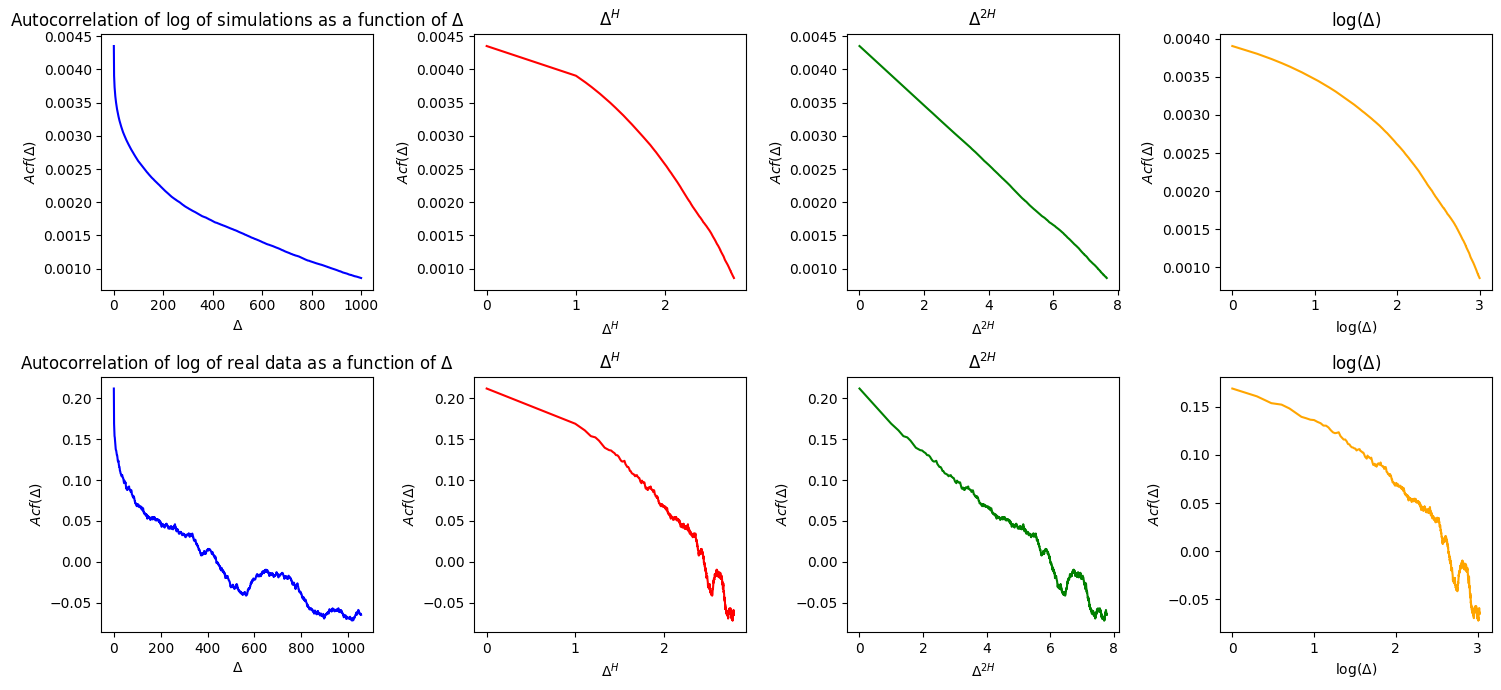

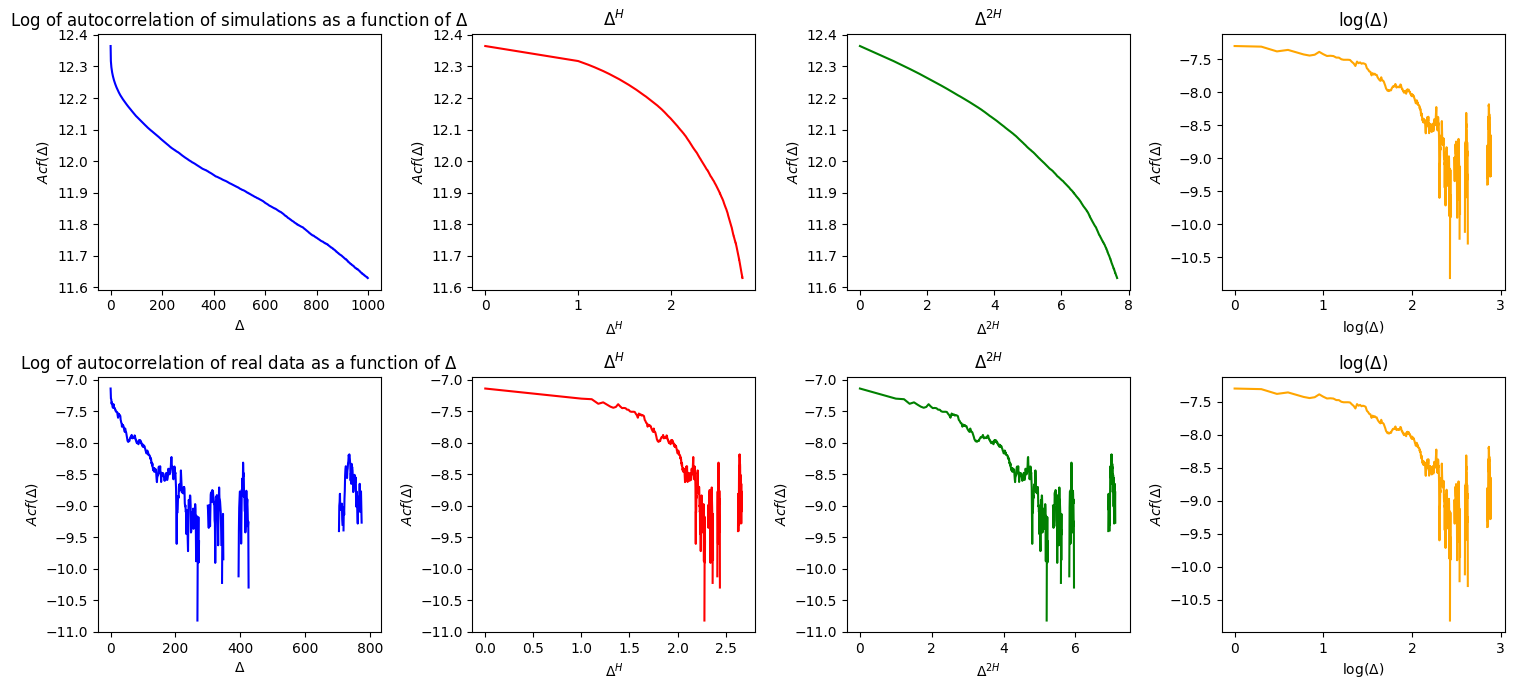

In [255]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,A1, color='blue')
plt.title(r'Autocorrelation of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,A1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),A1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4) 
plt.plot(np.log10(Delta),A1, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,A2, color='blue')
plt.title(r'Autocorrelation of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,A2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),A2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),A2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")


plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,C1, color='blue')
plt.title(r'Autocorrelation of log of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,C1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),C1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4) 
plt.plot(np.log10(Delta),C1, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,C2, color='blue')
plt.title(r'Autocorrelation of log of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,C2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),C2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),C2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,B1, color='blue')
plt.title(r'Log of autocorrelation of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,B1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),B1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4)
plt.plot(np.log10(Delta2),B2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,B2, color='blue')
plt.title(r'Log of autocorrelation of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,B2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),B2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),B2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.tight_layout()
plt.show()



We observe that ACF as a function of $\Delta^{2H}$ is linear